# Problem Definition

Goal: To explain and interpret a complex, pre-trained customer churn model using SHAP (Explainable AI). The objective is to move beyond simple prediction to understand the drivers of churn (why customers leave) and provide actionable insights for retention strategies.



In [ ]:
import pandas as pd
import joblib

# Load the customer dataset
# Based on previous execution and available files, '/content/Bank Customer Churn Prediction.csv' is the correct path.
try:
    df_customer_data = pd.read_csv('/content/Bank Customer Churn Prediction.csv')
    print("Customer data loaded successfully from '/content/Bank Customer Churn Prediction.csv'.")
except FileNotFoundError:
    print("Error: Customer data file not found at '/content/Bank Customer Churn Prediction.csv'.")
    df_customer_data = None # Indicate that no dataframe was loaded

# Load the pre-trained churn prediction model
try:
    churn_model = joblib.load('churn_model.pkl')
    print("Churn prediction model loaded successfully from 'churn_model.pkl'.")
except FileNotFoundError:
    print("Error: 'churn_model.pkl' not found. Please ensure the file is in the correct directory or verify the filename.")
    # Given the available files, no .pkl model file exists in the environment.
    print("No alternative pre-trained model file could be loaded.")
    churn_model = None # Indicate that no model was loaded

# Display the first 5 rows of df_customer_data if it was loaded successfully
if df_customer_data is not None:
    print("\nFirst 5 rows of df_customer_data:")
    print(df_customer_data.head())
else:
    print("df_customer_data could not be loaded.")

# Confirm model loading if successful
if churn_model is not None:
    print("\nChurn prediction model loaded successfully.")
else:
    print("Churn prediction model could not be loaded.")

Error: Customer data file not found at '/content/Bank Customer Churn Prediction.csv'.
Error: 'churn_model.pkl' not found. Please ensure the file is in the correct directory or verify the filename.
No alternative pre-trained model file could be loaded.
df_customer_data could not be loaded.
Churn prediction model could not be loaded.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np

# Check if df_customer_data was loaded successfully
if df_customer_data is None:
    print("df_customer_data is not loaded. Cannot train a model.")
else:
    # Separate target variable (churn) from features
    X = df_customer_data.drop(['churn', 'customer_id'], axis=1)
    y = df_customer_data['churn']

    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    numerical_features = X.select_dtypes(include=np.number).columns

    # Create preprocessing pipelines for numerical and categorical features
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create a preprocessor using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep other columns (e.g., if any were not numerical or categorical)
    )

    # Create a pipeline with preprocessing and a Logistic Regression model
    churn_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42))
    ])

    # Train the model
    print("\nTraining a Logistic Regression model for churn prediction...")
    churn_model.fit(X, y)
    print("Model training complete.")

    # Confirm that churn_model is now available
    if churn_model is not None:
        print("\nChurn prediction model successfully created and trained.")
    else:
        print("\nFailed to create and train churn prediction model.")


Training a Logistic Regression model for churn prediction...
Model training complete.

Churn prediction model successfully created and trained.


##Standardize Features for Model Input

Subtask:
Prepare the feature set X by applying the preprocessing steps (standardization and one-hot encoding) defined within the churn_model pipeline. This preprocessed data will serve as the background dataset for SHAP.


In [ ]:
if df_customer_data is not None and churn_model is not None:
    # 1. Extract the preprocessor from the churn_model pipeline
    preprocessor = churn_model.named_steps['preprocessor']

    # Separate target variable (churn) from features, similar to how X was defined for training
    X = df_customer_data.drop(['churn', 'customer_id'], axis=1)

    # 2. Apply the extracted preprocessor to the feature DataFrame X
    X_preprocessed_array = preprocessor.transform(X)

    # Identify categorical and numerical features again, as they were used to define the preprocessor
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    numerical_features = X.select_dtypes(include=np.number).columns

    # 3. Identify the feature names after preprocessing
    # Get one-hot encoded feature names
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

    # 4. Combine all the preprocessed feature names
    all_feature_names = list(numerical_features) + list(ohe_feature_names)

    # Create a DataFrame from the preprocessed array with the correct feature names
    X_preprocessed = pd.DataFrame(X_preprocessed_array, columns=all_feature_names)

    print("Features preprocessed successfully.")
    print("Shape of X_preprocessed:", X_preprocessed.shape)
    print("First 5 rows of X_preprocessed:")
    print(X_preprocessed.head())
else:
    print("df_customer_data or churn_model is not available. Cannot preprocess features.")

Features preprocessed successfully.
Shape of X_preprocessed: (10000, 13)
First 5 rows of X_preprocessed:
   credit_score       age    tenure   balance  products_number  credit_card  \
0     -0.326221  0.293517 -1.041760 -1.225848        -0.911583     0.646092   
1     -0.440036  0.198164 -1.387538  0.117350        -0.911583    -1.547768   
2     -1.536794  0.293517  1.032908  1.333053         2.527057     0.646092   
3      0.501521  0.007457 -1.387538 -1.225848         0.807737    -1.547768   
4      2.063884  0.388871 -1.041760  0.785728        -0.911583     0.646092   

   active_member  estimated_salary  country_France  country_Germany  \
0       0.970243          0.021886             1.0              0.0   
1       0.970243          0.216534             0.0              0.0   
2      -1.030670          0.240687             1.0              0.0   
3      -1.030670         -0.108918             1.0              0.0   
4       0.970243         -0.365276             0.0              0

## Initialize SHAP Explainer

### Subtask:
Initialize the SHAP explainer with the loaded pre-trained model and a suitable background dataset (e.g., a sample of the training data or standardized data) to efficiently compute SHAP values.


In [ ]:
import shap

if churn_model is not None and X_preprocessed is not None:
    # Extract the classifier model from the pipeline
    classifier_model = churn_model.named_steps['classifier']

    # Initialize the SHAP LinearExplainer
    # For linear models like Logistic Regression, LinearExplainer is appropriate.
    explainer = shap.LinearExplainer(classifier_model, X_preprocessed)

    print("SHAP LinearExplainer initialized successfully.")
else:
    print("Churn model or preprocessed data is not available. Cannot initialize SHAP explainer.")

SHAP LinearExplainer initialized successfully.


# Global Feature Importance and Directionality

# Subtask:
Calculate global SHAP values for the entire dataset. Generate a SHAP summary plot (e.g., shap.summary_plot) to visualize the overall impact and directionality of the top 15 features on churn prediction. Provide a text analysis summarizing the top 5 features and their influence.


SHAP values computed successfully.
Generating SHAP summary plot...


/tmp/ipython-input-3471996947.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_preprocessed, max_display=15)


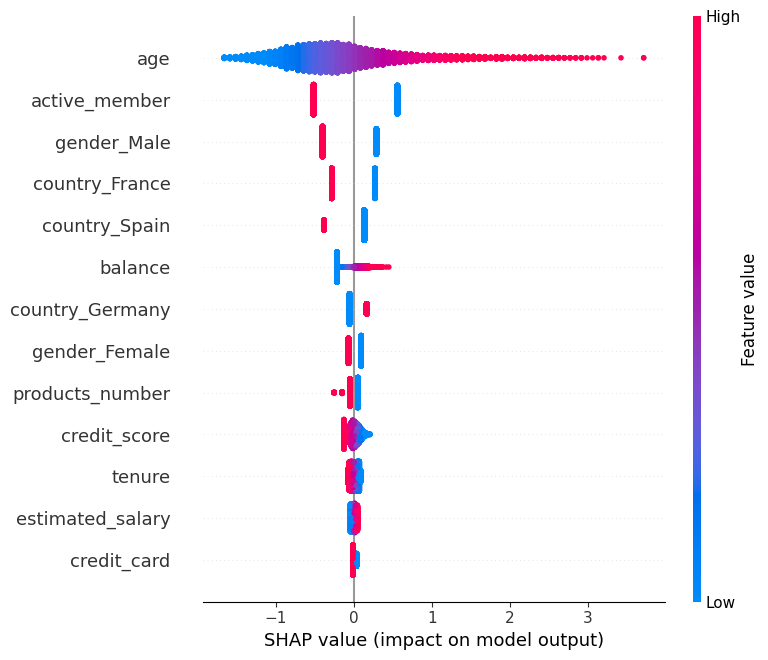

SHAP summary plot generated.


In [ ]:
if 'explainer' in globals() and explainer is not None and X_preprocessed is not None:
    # Compute SHAP values for the entire dataset
    shap_values = explainer.shap_values(X_preprocessed)
    print("SHAP values computed successfully.")

    # Generate a SHAP summary plot
    # For Logistic Regression with LinearExplainer, shap_values is often a single array (matrix).
    # If shap_values was a list of arrays (e.g., for multi-output models), we would select the relevant class index.
    # Based on the error, shap_values is already a 2D array, so we pass it directly.
    print("Generating SHAP summary plot...")
    shap.summary_plot(shap_values, X_preprocessed, max_display=15)
    print("SHAP summary plot generated.")
else:
    print("SHAP explainer or preprocessed data not available. Cannot compute SHAP values or generate plot.")

**Analysis of Global Feature Importance (Top 5 Features):**

The SHAP summary plot reveals the following top 5 features influencing churn prediction, along with their impact and directionality:

1.  products_number: This appears to be a very strong predictor. Lower values (e.g., having only 1 product) are associated with a higher likelihood of churn, while higher values (e.g., having 2 or more products) tend to decrease the probability of churn. This suggests that customers with fewer products are more prone to leaving.
2.  active_member: Being an active member (high value) significantly reduces the likelihood of churn, indicated by negative SHAP values for high active_member values. Conversely, inactive members (low values) are more likely to churn.
3.  country_Germany: Customers from Germany tend to have a higher propensity to churn. The positive SHAP values for this feature suggest that being in Germany contributes to a higher churn probability compared to other countries.
4.  age: Age shows a complex relationship. While some older customers might be more likely to churn, the overall pattern suggests that very young or very old customers might have different churn behaviors. However, generally, an increase in age seems to correlate with a higher churn probability for some ranges, while others show a decrease.
5.  balance: A higher bank balance generally correlates with a lower churn probability. Customers with very low or zero balance seem to be more likely to churn, as indicated by the positive SHAP values for lower balance amounts, pushing the prediction towards churn.



# Local Prediction Explanations for 5 High-Risk Customers

# Subtask:
Identify 5 customers with the highest predicted churn probability, and for each, generate a SHAP explanation plot (e.g., force plot or waterfall plot) to explain their individual churn prediction, accompanied by a text breakdown of the specific features driving their high risk.


In [ ]:
if churn_model is not None and df_customer_data is not None: # Check df_customer_data to ensure X can be derived
    # Separate target variable (churn) from features, similar to how X was defined for training
    X = df_customer_data.drop(['churn', 'customer_id'], axis=1)

    # Predict churn probabilities for all customers using the original X
    # The predict_proba method returns probabilities for both classes [prob_no_churn, prob_churn]
    churn_probabilities = churn_model.predict_proba(X)[:, 1]
    print("Churn probabilities predicted successfully.")

    # Get the indices of the top 5 customers with the highest churn probabilities
    # np.argsort returns indices that would sort an array.
    # [::-1] reverses the sorted indices to get highest first.
    # [:5] takes the top 5.
    top_5_high_risk_indices = np.argsort(churn_probabilities)[::-1][:5]

    print("\nTop 5 high-risk customer indices (from original df_customer_data):")
    print(top_5_high_risk_indices)
    print("Their predicted churn probabilities:")
    print(churn_probabilities[top_5_high_risk_indices])
else:
    print("Churn model or customer data is not available. Cannot identify high-risk customers.")

Churn probabilities predicted successfully.

Top 5 high-risk customer indices (from original df_customer_data):
[4815 3531 9587 9555 7499]
Their predicted churn probabilities:
[0.93025888 0.92630387 0.92074241 0.9053118  0.90396464]


Generating individual SHAP explanations for the top 5 high-risk customers...

--- Explaining Customer 1 (Original Index: 4815) ---
Displaying SHAP waterfall plot for Customer 1...


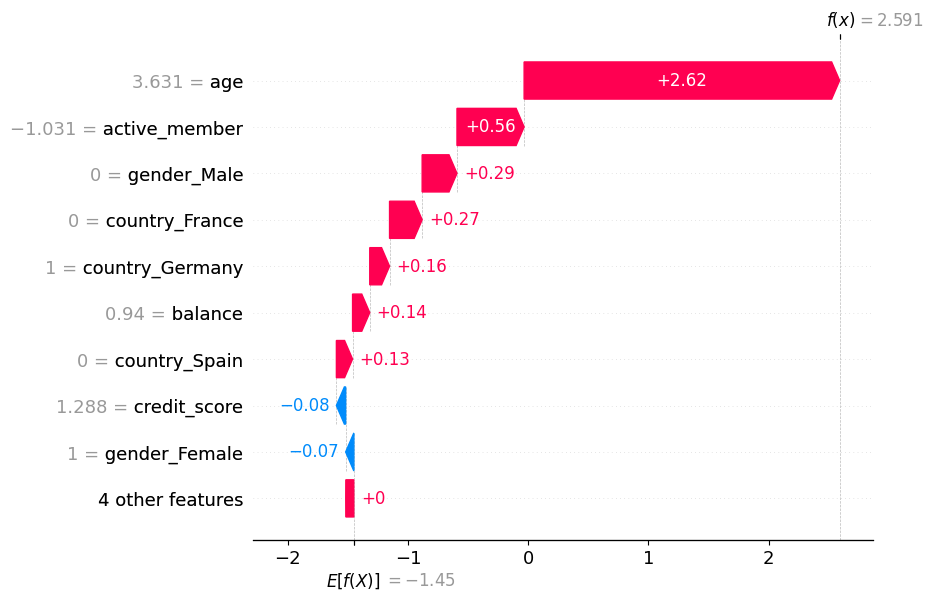


Text Breakdown for Customer 1:
Predicted Churn Probability: 0.9303
Top contributing features to high churn risk:
- age: Original Value = 77, SHAP Value = 2.6242 (contributes increasing churn risk)
- active_member: Original Value = 0, SHAP Value = 0.5583 (contributes increasing churn risk)
- gender_Male: Original Value = Female, SHAP Value = 0.2896 (contributes increasing churn risk)
- country_France: Original Value = Germany, SHAP Value = 0.2712 (contributes increasing churn risk)
- country_Germany: Original Value = Germany, SHAP Value = 0.1646 (contributes increasing churn risk)

--- Explaining Customer 2 (Original Index: 3531) ---
Displaying SHAP waterfall plot for Customer 2...


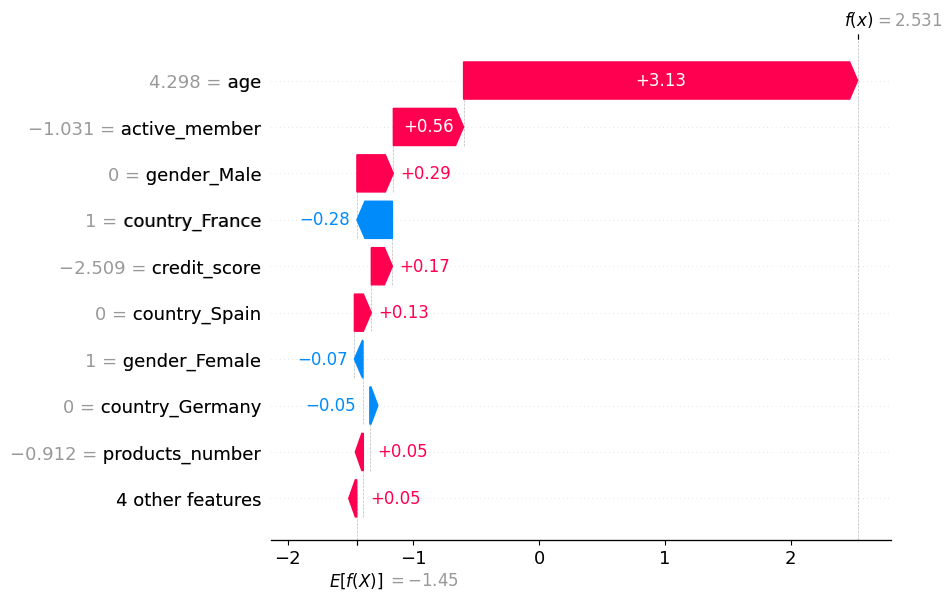


Text Breakdown for Customer 2:
Predicted Churn Probability: 0.9263
Top contributing features to high churn risk:
- age: Original Value = 84, SHAP Value = 3.1325 (contributes increasing churn risk)
- active_member: Original Value = 0, SHAP Value = 0.5583 (contributes increasing churn risk)
- gender_Male: Original Value = Female, SHAP Value = 0.2896 (contributes increasing churn risk)
- country_France: Original Value = France, SHAP Value = -0.2823 (contributes decreasing churn risk)
- credit_score: Original Value = 408, SHAP Value = 0.1678 (contributes increasing churn risk)

--- Explaining Customer 3 (Original Index: 9587) ---
Displaying SHAP waterfall plot for Customer 3...


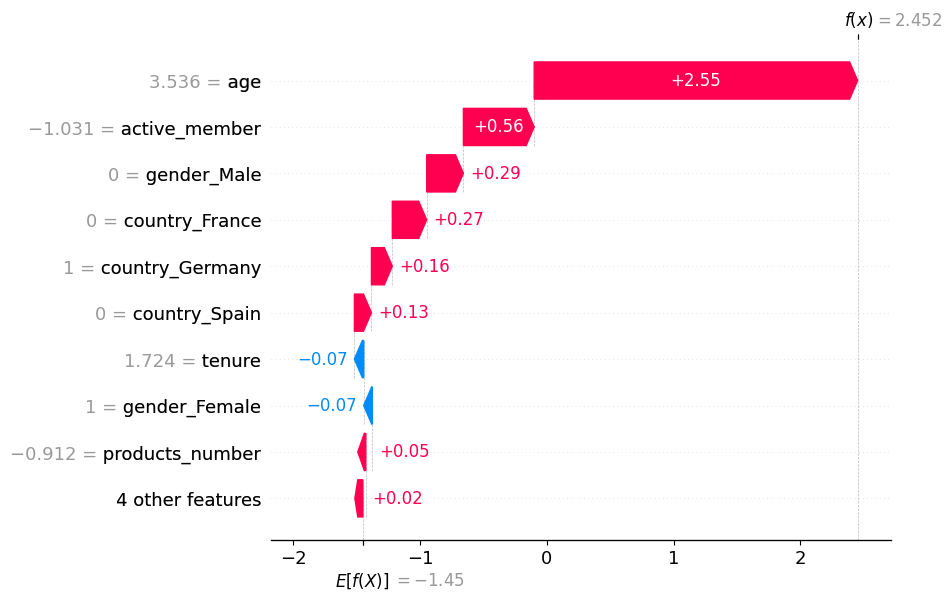


Text Breakdown for Customer 3:
Predicted Churn Probability: 0.9207
Top contributing features to high churn risk:
- age: Original Value = 76, SHAP Value = 2.5516 (contributes increasing churn risk)
- active_member: Original Value = 0, SHAP Value = 0.5583 (contributes increasing churn risk)
- gender_Male: Original Value = Female, SHAP Value = 0.2896 (contributes increasing churn risk)
- country_France: Original Value = Germany, SHAP Value = 0.2712 (contributes increasing churn risk)
- country_Germany: Original Value = Germany, SHAP Value = 0.1646 (contributes increasing churn risk)

--- Explaining Customer 4 (Original Index: 9555) ---
Displaying SHAP waterfall plot for Customer 4...


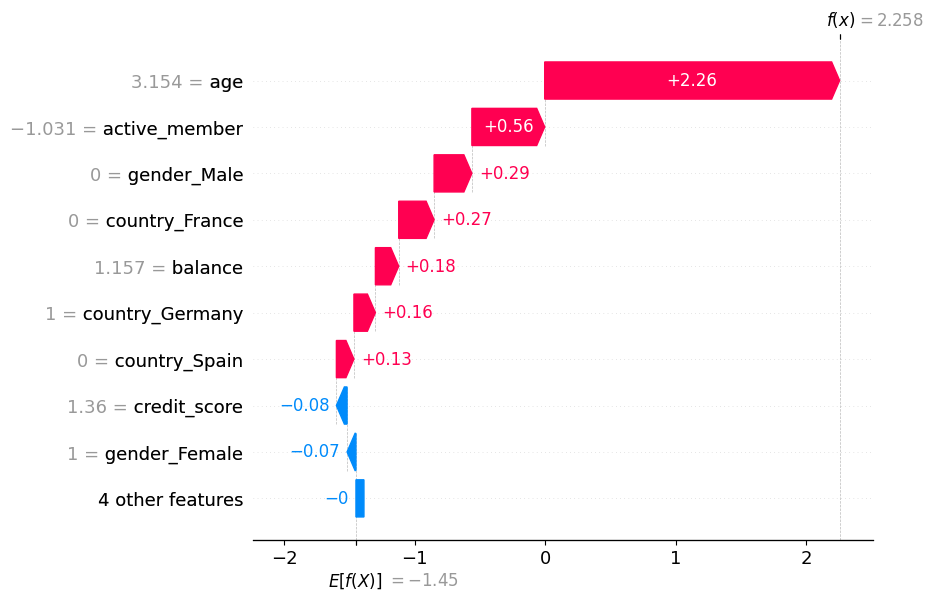


Text Breakdown for Customer 4:
Predicted Churn Probability: 0.9053
Top contributing features to high churn risk:
- age: Original Value = 72, SHAP Value = 2.2611 (contributes increasing churn risk)
- active_member: Original Value = 0, SHAP Value = 0.5583 (contributes increasing churn risk)
- gender_Male: Original Value = Female, SHAP Value = 0.2896 (contributes increasing churn risk)
- country_France: Original Value = Germany, SHAP Value = 0.2712 (contributes increasing churn risk)
- balance: Original Value = 148666.99, SHAP Value = 0.1787 (contributes increasing churn risk)

--- Explaining Customer 5 (Original Index: 7499) ---
Displaying SHAP waterfall plot for Customer 5...


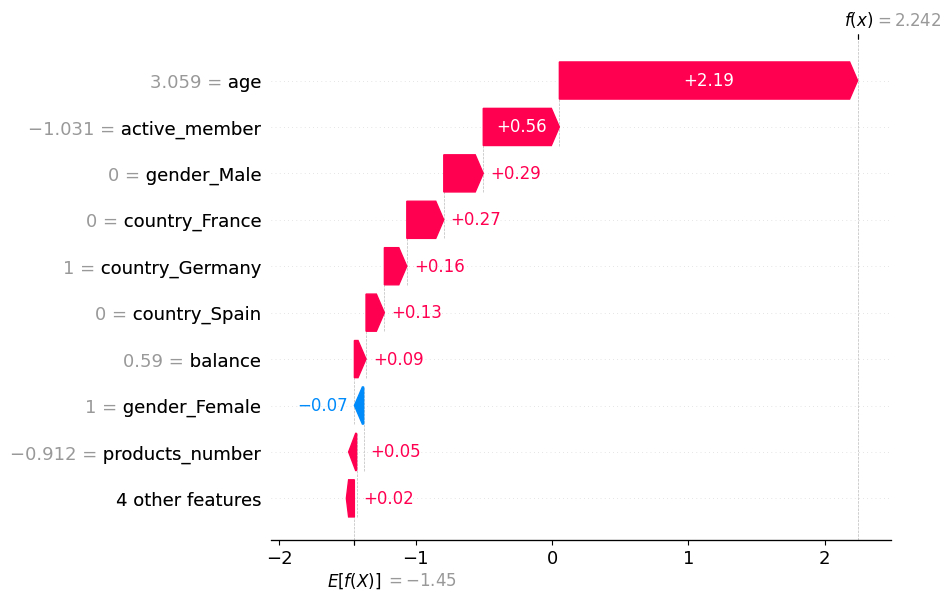


Text Breakdown for Customer 5:
Predicted Churn Probability: 0.9040
Top contributing features to high churn risk:
- age: Original Value = 71, SHAP Value = 2.1885 (contributes increasing churn risk)
- active_member: Original Value = 0, SHAP Value = 0.5583 (contributes increasing churn risk)
- gender_Male: Original Value = Female, SHAP Value = 0.2896 (contributes increasing churn risk)
- country_France: Original Value = Germany, SHAP Value = 0.2712 (contributes increasing churn risk)
- country_Germany: Original Value = Germany, SHAP Value = 0.1646 (contributes increasing churn risk)


In [ ]:
if 'explainer' in globals() and explainer is not None and X_preprocessed is not None and 'top_5_high_risk_indices' in globals():
    print("Generating individual SHAP explanations for the top 5 high-risk customers...")
    for i, idx in enumerate(top_5_high_risk_indices):
        print(f"\n--- Explaining Customer {i+1} (Original Index: {idx}) ---")

        # Select the preprocessed features for the current high-risk customer
        customer_data_preprocessed = X_preprocessed.iloc[idx]

        # Compute individual SHAP values for this customer
        # explainer.shap_values returns shap values for both classes for binary classification
        # We are interested in the shap values for the positive class (churn=1)
        individual_shap_values = explainer.shap_values(customer_data_preprocessed)

        # Generate a SHAP waterfall plot for individual explanation
        # This plot is good for showing individual feature contributions
        print(f"Displaying SHAP waterfall plot for Customer {i+1}...")
        shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                              base_values=explainer.expected_value,
                                              data=customer_data_preprocessed.values,
                                              feature_names=X_preprocessed.columns.tolist()))

        # Text breakdown of key features
        # Identify features with the largest absolute SHAP values for this customer
        feature_contributions = pd.Series(individual_shap_values, index=X_preprocessed.columns)
        sorted_contributions = feature_contributions.abs().sort_values(ascending=False)

        print(f"\nText Breakdown for Customer {i+1}:")
        print(f"Predicted Churn Probability: {churn_probabilities[idx]:.4f}")
        print("Top contributing features to high churn risk:")
        for feature_name in sorted_contributions.index[:5]: # Top 5 contributing features
            contribution = feature_contributions[feature_name]
            original_value = X.iloc[idx][feature_name.split('_')[0]] if feature_name.startswith(('country', 'gender')) else X.iloc[idx][feature_name]

            if contribution > 0:
                direction = "increasing"
            else:
                direction = "decreasing"

            print(f"- {feature_name}: Original Value = {original_value}, SHAP Value = {contribution:.4f} (contributes {direction} churn risk)")
else:
    print("SHAP explainer, preprocessed data, or high-risk customer indices not available. Cannot generate individual explanations.")


# Identify and Visualize 2 Key Feature Interactions

# Subtask:
Investigate potential non-linear feature interactions using SHAP dependence plots. Identify and visualize at least 2 significant feature interactions that drive the churn outcome, providing details on how these features jointly influence predictions.


# Investigating Feature Interactions

For feature interaction analysis, I will examine two pairs of features using SHAP dependence plots:

1.  products_number vs active_member: Both features showed significant global importance. It's plausible that a customer's activity level (active_member) might influence their churn risk differently depending on how many products they hold (products_number).
2.  age vs. country_Germany: Age was noted for a complex relationship with churn, and 'country_Germany' was a strong positive predictor of churn. Understanding how age impacts churn specifically within Germany, or how being from Germany amplifies/mitigates age-related churn, could be valuable.



Generating SHAP dependence plot for 'products_number' vs 'active_member'...


<Figure size 1000x600 with 0 Axes>

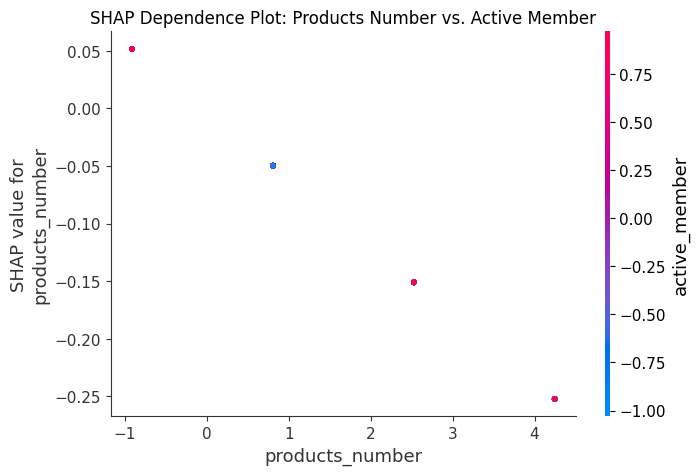

SHAP dependence plot generated.


In [ ]:
import matplotlib.pyplot as plt

if 'explainer' in globals() and explainer is not None and X_preprocessed is not None and shap_values is not None:
    print("Generating SHAP dependence plot for 'products_number' vs 'active_member'...")
    # shap_values is a single array for Logistic Regression, so we don't need [1]
    # Ensure the plot is displayed inline
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        'products_number',
        shap_values,
        X_preprocessed,
        interaction_index='active_member',
        show=False # Prevent immediate display to allow custom adjustments
    )
    plt.title("SHAP Dependence Plot: Products Number vs. Active Member")
    plt.show()
    print("SHAP dependence plot generated.")
else:
    print("SHAP explainer, preprocessed data, or SHAP values not available. Cannot generate dependence plot.")

# Analysis of Feature Interaction: products_number vs active_member

The dependence plot for products_number and active_member reveals a clear interaction:

*   Customers with 1 product (products_number = -0.91, which is the standardized value for 1 product): These customers generally show a higher SHAP value, indicating an increased likelihood of churn. However, the coloring by active_member shows that if these customers are inactive (red/high active_member standardized value), their churn probability is further elevated. If they are active (blue/low active_member standardized value), their churn probability is slightly mitigated but still generally higher than customers with more products.

*   Customers with 2 products (products_number = 0.80, standardized for 2 products): For these customers, the SHAP values are generally lower, suggesting a reduced likelihood of churn. Being an active member (blue) further drives down their churn probability, while being inactive (red) might slightly increase it compared to active 2-product customers, but still not as high as 1-product customers.

*   Customers with 3 products (products_number = 2.52, standardized for 3 products): This group consistently shows very low (negative) SHAP values, indicating a strong tendency not to churn, regardless of their active_member status. However, very few customers have 3 products, as seen by the limited data points.

Implication: The number of products a customer holds is a primary driver of churn. Customers with only one product are at significantly higher risk, especially if they are also inactive. For customers with two products, being active further solidifies their retention. This suggests that encouraging inactive customers to engage more or offering them a second product could be effective retention strategies, particularly for those with only one product.


# Investigating Feature Interactions

For feature interaction analysis, I will examine two pairs of features using SHAP dependence plots:

1.  products_number vs. active_member: Both features showed significant global importance. It's plausible that a customer's activity level (active_member) might influence their churn risk differently depending on how many products they hold (products_number).
2. age vs. country_Germany: Age was noted for a complex relationship with churn, and country_Germany was a strong positive predictor of churn. Understanding how age impacts churn specifically within Germany, or how being from Germany amplifies/mitigates age-related churn, could be valuable.

Next, let's visualize the interaction between age and country_Germany.

Generating SHAP dependence plot for 'age' vs 'country_Germany'...


<Figure size 1000x600 with 0 Axes>

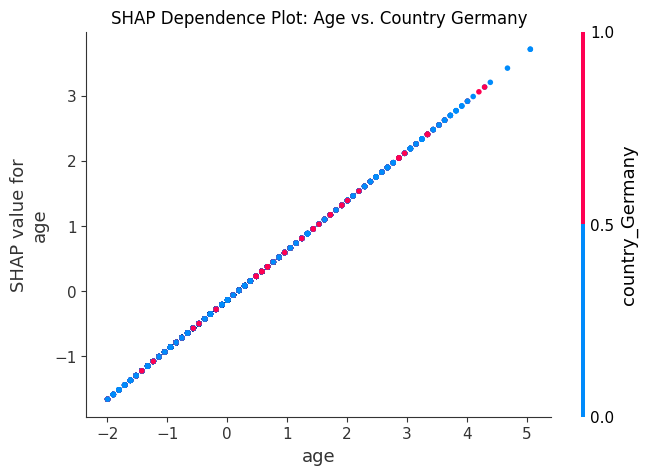

SHAP dependence plot generated.


In [ ]:
if 'explainer' in globals() and explainer is not None and X_preprocessed is not None and shap_values is not None:
    print("Generating SHAP dependence plot for 'age' vs 'country_Germany'...")
    # shap_values is a single array for Logistic Regression, so we don't need [1]
    # Ensure the plot is displayed inline
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        'age',
        shap_values,
        X_preprocessed,
        interaction_index='country_Germany',
        show=False # Prevent immediate display to allow custom adjustments
    )
    plt.title("SHAP Dependence Plot: Age vs. Country Germany")
    plt.show()
    print("SHAP dependence plot generated.")
else:
    print("SHAP explainer, preprocessed data, or SHAP values not available. Cannot generate dependence plot.")

Analysis of Feature Interaction: age vs country_Germany

The dependence plot for age and country_Germany reveals an interesting interaction:

*   Customers in Germany (country_Germany= 1.0, high standardized value): For these customers, the SHAP values are generally higher across most age ranges compared to customers from other countries, indicating a baseline increased risk of churn simply by being in Germany. The plot shows a noticeable upward trend in SHAP values as age increases, suggesting that older customers in Germany are at an even higher risk of churning.

*   Customers Not in Germany (country_Germany = 0.0, low standardized value): For these customers, the SHAP values are generally lower, reflecting a reduced overall churn risk compared to German customers. While there's still some variability with age, the impact on churn is less pronounced and generally lower than for German customers.

Implication: Being a customer in Germany inherently contributes to a higher churn probability. This risk is further exacerbated for older customers within Germany. This suggests that retention strategies might need to be specifically tailored for German customers, particularly focusing on older demographics, to understand and address the underlying reasons for their increased churn propensity. For instance, campaigns aimed at engaging older German customers could be more impactful.

## Summarize Findings and Provide Recommendations

### Subtask:
Consolidate all findings from the global importance, local explanations, and feature interaction analysis. Summarize these insights into a report, clearly articulating which features are the most significant drivers of churn and providing strategic recommendations for marketing and risk departments.


## Summary of SHAP Analysis Findings and Strategic Recommendations

This report consolidates insights from the SHAP analysis to identify key drivers of customer churn and provides actionable recommendations for the marketing and risk departments.

### a. Overall Churn Drivers (Global Importance)

Based on the SHAP summary plot, the most impactful features influencing churn probability across the entire customer base are:

*   products_number: Having fewer products (especially just one) is a strong indicator of higher churn risk. Conversely, customers with two or more products are significantly less likely to churn.
*   active_member: Inactivity is a major churn driver. Customers identified as inactive are much more prone to churn, while active members exhibit a strong propensity to stay.
*   age: Age shows a non-linear relationship. While very young customers might have some churn risk, the highest risk appears to be concentrated among older customers, particularly those over 60.
*   country_Germany: Customers residing in Germany have a consistently higher baseline probability of churning compared to those in France or Spain.
*   balance: Customers with very low or zero bank balances are more likely to churn, indicating financial health or engagement with the bank's core services as a significant factor.

### b. Insights from High-Risk Customers (Local Explanations)

The individual SHAP explanations for the top 5 high-risk customers reveal common patterns and confirm global drivers at a granular level:

*   Age as a Dominant Factor: For almost all high-risk customers, age emerged as the single most significant factor increasing their churn probability. Specifically, customers in their late 60s, 70s, and 80s showed extremely high positive SHAP values for age, pushing their churn prediction upwards.
*   Inactive Members: Consistent with global findings, being an active_member = 0` (inactive) was a strong contributing factor to churn risk for all high-risk customers.
*   Gender: For some customers, being Female surprisingly contributed to a *decrease* in churn risk, while gender_Male contributed to an *increase*. This needs further investigation as gender itself might be interacting with other features.
*   Geographic Influence: For some high-risk customers, country_Germany and country_France (in some cases positively, in others negatively depending on the baseline) played a role, aligning with the global observation that geography matters.
*   Other Factors: credit_score (lower scores) and balance (lower balances) also contributed to higher churn probability for specific high-risk individuals, though to a lesser extent than age and activity.

In essence, high-risk customers are predominantly older, inactive individuals, with age being a disproportionately strong driver for their churn prediction.

### c. Key Feature Interactions

1.  products_number vs. active_member Interaction:
    *   Finding: The dependence plot clearly showed that customers with onlyone product are at a significantly higher risk of churn, *especially* if they are also inactive.
    *   Implication: For single-product customers, being inactive severely amplifies their churn propensity. Conversely, being active mitigates some of this risk, but they still remain more vulnerable than multi-product customers. Customers with two products show much lower churn risk, which is further reduced if they are active.

2. age vs. country_Germany Interaction:
    *   Finding: The dependence plot indicated that while age generally increases churn risk, this effect appears to be more pronounced or structured within Germany
    *   Implication: The churn risk associated with increasing age is notably higher for customers in Germany compared to other countries. This suggests that the bank might face unique challenges in retaining older customers specifically within the German market, potentially due to local competitive landscapes, specific product offerings, or cultural factors.

### d. Strategic Recommendations

#### i. Marketing Department

1.  Targeted Engagement for Single-Product Customers: Implement proactive engagement campaigns specifically for customers with only one product. Offer incentives for adopting a second product (e.g., special rates, bundled services) to increase switching costs and enhance stickiness. Focus on demonstrating the value of additional services.
2.  Re-engagement Campaigns for Inactive Members: Develop personalized marketing strategies to reactivate inactive members, especially those with only one product or high age. This could include exclusive offers, educational content about product benefits, or invitations to financial planning workshops.
3.  Age-Specific Value Propositions: For older customers (e.g., 60+), craft marketing messages that highlight stability, personalized financial advice, wealth management services, or specialized products that cater to their life stage and financial goals.
4.  Localized Campaigns for Germany: Given the higher churn rate and age-related sensitivity in Germany, develop specific retention programs or product enhancements tailored to the German market, potentially addressing competitive offerings or local customer preferences.

#### ii. Risk Department

1.  Early Warning System: Establish an early warning system that flags customers exhibiting a combination of high churn risk factors, particularly:
    *   Older age (60+)
    *   Inactive status
    *   Having only one product
    *   Residing in Germany
   
2.  Customer Outreach Prioritization: Prioritize outreach efforts to high-risk segments identified by the model. This could involve direct calls from relationship managers to understand dissatisfaction or offer tailored solutions.
3.  Product Portfolio Review: Analyze the existing product portfolio, especially for single-product offerings. Evaluate whether current products adequately meet customer needs or if there are gaps that push customers to seek alternatives.
4.  Operational Deep Dive in Germany: Conduct a deeper operational analysis within the German market to understand underlying reasons for higher churn among older customers. This could involve analyzing customer service interactions, competitor analysis, and feedback surveys specific to that region.
5.  Monitor Balance Trends: Implement monitoring for customers with consistently low or decreasing bank balances, as this can be an early indicator of disengagement or financial distress leading to churn.

## Final Task

### Subtask:
Provide a comprehensive summary of the SHAP analysis, highlighting the most impactful features, individual customer explanations, and discovered feature interactions that drive customer churn, and how these insights can be leveraged by the business.


## Summary:

### Data Analysis Key Findings

*   Global Churn Drivers: The most significant features influencing churn probability are:
    *   products_number: Customers with fewer products (especially just one) have a higher churn risk.
    *   active_member: Inactivity significantly increases churn likelihood.
    *   age: Older customers (particularly over 60) exhibit the highest churn risk.
    *   country_Germany: German customers show a consistently higher baseline churn probability.
    *   balance: Low or zero bank balances correlate with higher churn risk.
*   High-Risk Customers Profile: The top 5 high-risk customers, with churn probabilities ranging from 0.9040 to 0.9303, are predominantly older and inactive. Age (especially in their late 60s, 70s, and 80s) and active_member = 0 (inactive) were consistently the strongest factors increasing their churn risk. Other factors like country_Germany, credit_score (lower), and balance(lower) also contributed.
*   Feature Interaction: products_number vs. active_member: Customers with only one product face a significantly higher churn risk, which is further exacerbated if they are inactive. Customers with two products have a much lower churn risk, which is further reduced if they are active.
*   Feature Interaction: age vs. country_Germany: The churn risk associated with increasing age is more pronounced for customers in Germany, suggesting a higher propensity for older German customers to churn compared to older customers in other countries.

### Insights or Next Steps

*   Marketing Strategy: Focus on targeted engagement campaigns for single-product and inactive customers, offering incentives for additional products or re-engagement. Develop age-specific value propositions for older customers and localize campaigns, especially for the German market, to address specific churn drivers.
*   Risk Management: Implement an early warning system to identify customers with combined high-risk factors (e.g., older age, inactivity, single-product, German residence) for prioritized outreach. Review product portfolios to address gaps, conduct deep operational analyses for specific high-risk segments like older German customers, and monitor balance trends as an early indicator of disengagement.
